### Imports

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import get_from_s3

### Get annotations and corresponding image ids

In [20]:
df_annotations, df_images = get_from_s3.get_annotations()
img_id = df_images['image_id'][0]

### Get Image

In [21]:
image = get_from_s3.get_image_s3(img_id)

### Some configuration

In [12]:
# --- Configure which columns mean what in your annotations table ---
COL_X = "col"
COL_Y = "row"
COL_BENTHIC = "benthic_attribute_name"   
COL_GROWTH  = "growth_form_name"         
COL_COLOR   = "benthic_color"            # optional precomputed color column
COL_MARKER  = "growth_form_marker"       # optional precomputed marker column

### Fill missing entries with consistent value in the annotations dataframe

In [13]:
# --- Normalize blanks in growth form ---
annotations = df_annotations.loc[df_annotations['image_id'] == img_id] # get annotations for image with img_id.
annotations = annotations.copy()
annotations[COL_GROWTH] = annotations[COL_GROWTH].fillna("None")
annotations.loc[annotations[COL_GROWTH].eq(""), COL_GROWTH] = "None"
# ^ replaces N/A and "" with "None"

### Give colours to each Benthic Attribute Name

In [14]:
# --- Make/choose colors for benthic attributes ---
def make_color_lookup(df):
    if COL_COLOR in df.columns and df[COL_COLOR].notna().any():
        # Prefer your provided colors if present
        return {row[COL_BENTHIC]: row[COL_COLOR]
                for _, row in df[[COL_BENTHIC, COL_COLOR]].dropna().drop_duplicates().iterrows()}
    # Otherwise auto-assign from a qualitative palette
    benthics = df[COL_BENTHIC].dropna().unique().tolist()
    cmap = plt.get_cmap("tab20")  # 20 distinct-ish colors
    return {b: cmap(i % 20) for i, b in enumerate(sorted(benthics))}

In [16]:
# --- Make/choose markers for growth forms ---
# Reserve "s" (square) only for the "None" category
DEFAULT_MARKERS = ['o', '^', 'D', 'P', 'X', 'v', '<', '>', '*', 'h', 'H', 'p']  # no 's' here

def make_marker_lookup(df):
    # If your data already provides a marker column, honor it
    if COL_MARKER in df.columns and df[COL_MARKER].notna().any():
        return {row[COL_GROWTH]: row[COL_MARKER]
                for _, row in df[[COL_GROWTH, COL_MARKER]].dropna().drop_duplicates().iterrows()}
    # Otherwise assign from defaults, then force "None" -> square
    growths = df[COL_GROWTH].unique().tolist()
    lut = {g: DEFAULT_MARKERS[i % len(DEFAULT_MARKERS)] for i, g in enumerate(sorted(growths))}
    if "None" in growths:
        lut["None"] = "s"  # square reserved only for "None"
    return lut

In [17]:
# --- Legend builders  ---
def get_legend_elements_from_df(df, color_lut, marker_lut):
    from matplotlib.lines import Line2D

    # Benthic legend (unchanged)
    benthic_handles = [
        Line2D([0],[0], marker='o', linestyle='None', markersize=8,
               markerfacecolor=color_lut[b], markeredgecolor='black',
               markeredgewidth=0.5, label=b)
        for b in sorted(color_lut)
    ]

    # Growth-form legend with "None" last
    keys = list(marker_lut.keys())
    # sort alphabetically, but make "None" come last
    keys.sort(key=lambda k: (str(k).lower() == "none", str(k).lower()))

    growth_handles = [
        Line2D([0],[0], marker=marker_lut[g], linestyle='None', markersize=8,
               markerfacecolor='white', markeredgecolor='black',
               markeredgewidth=0.8, label=g)
        for g in keys
    ]
    return benthic_handles, growth_handles

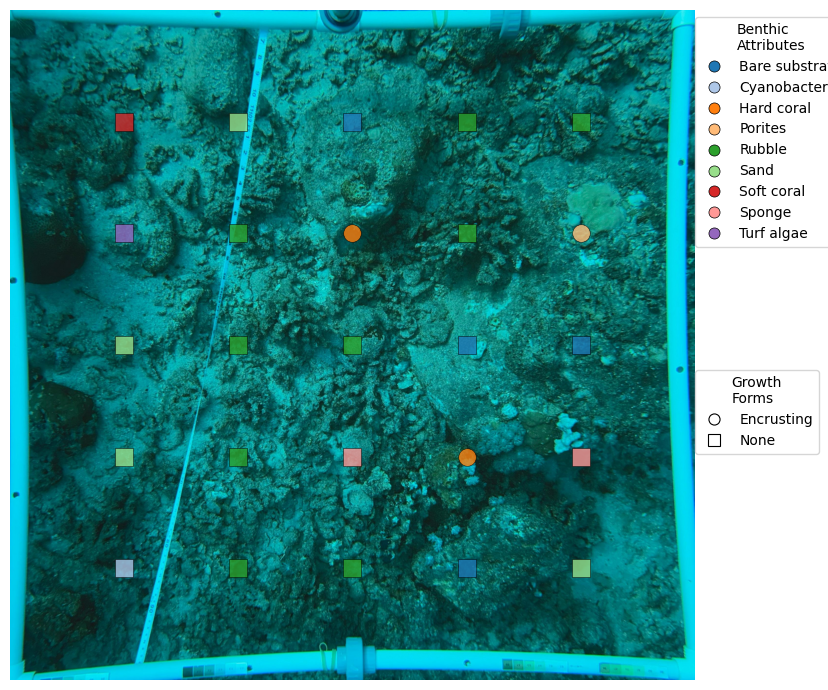

In [22]:
# --- Build lookups from your annotations DataFrame ---
color_lut  = make_color_lookup(annotations)
marker_lut = make_marker_lookup(annotations)

# --- Plot ---
fig, ax = plt.subplots(figsize=(8.5, 7), layout="tight")

# If image is a PIL.Image, matplotlib handles it; if ndarray, that’s fine too
ax.imshow(image)

# Plot each annotated point
# Use itertuples() for speed; fall back to dict lookups for color/marker
for row in annotations.itertuples(index=False):
    x = getattr(row, COL_X)
    y = getattr(row, COL_Y)
    benthic = getattr(row, COL_BENTHIC, None)
    growth  = getattr(row, COL_GROWTH, None)
    color   = getattr(row, COL_COLOR, None) if COL_COLOR in annotations.columns else None
    marker  = getattr(row, COL_MARKER, None) if COL_MARKER in annotations.columns else None
    # Fallbacks if explicit cols missing
    if color is None and benthic is not None:
        color = color_lut.get(benthic, 'tab:gray')
    if marker is None and growth is not None:
        marker = marker_lut.get(growth, 'o')

    ax.scatter(x, y, c=[color], marker=marker, s=160, alpha=0.8, edgecolors='black', linewidths=0.4)

# Legends
benthic_legend_elements, growth_legend_elements = get_legend_elements_from_df(
    annotations, color_lut, marker_lut
)
first_legend = ax.legend(handles=benthic_legend_elements, bbox_to_anchor=(0.99, 1.0),
                         loc='upper left', title='Benthic\nAttributes', frameon=True)
ax.add_artist(first_legend)

ax.legend(handles=growth_legend_elements, bbox_to_anchor=(0.99, 0.40),
          loc='center left', title='Growth\nForms', frameon=True)

ax.axis("off")
plt.show()